**Подготовка colab notebook**

1.Скопируйте этот colab (go to File-->Save copy in Drive)

2.В открывшемся новом colab:

переименуйте название следующим образом "Тестовое задание ShiftLab 2021 computer vision [ваше имя фамилия].ipynb" 

например,
"Тестовое задание ShiftLab 2021 computer vision  Иван Иванов.ipynb"


#Необходимо создать и обучить multi-output классификатор изображений







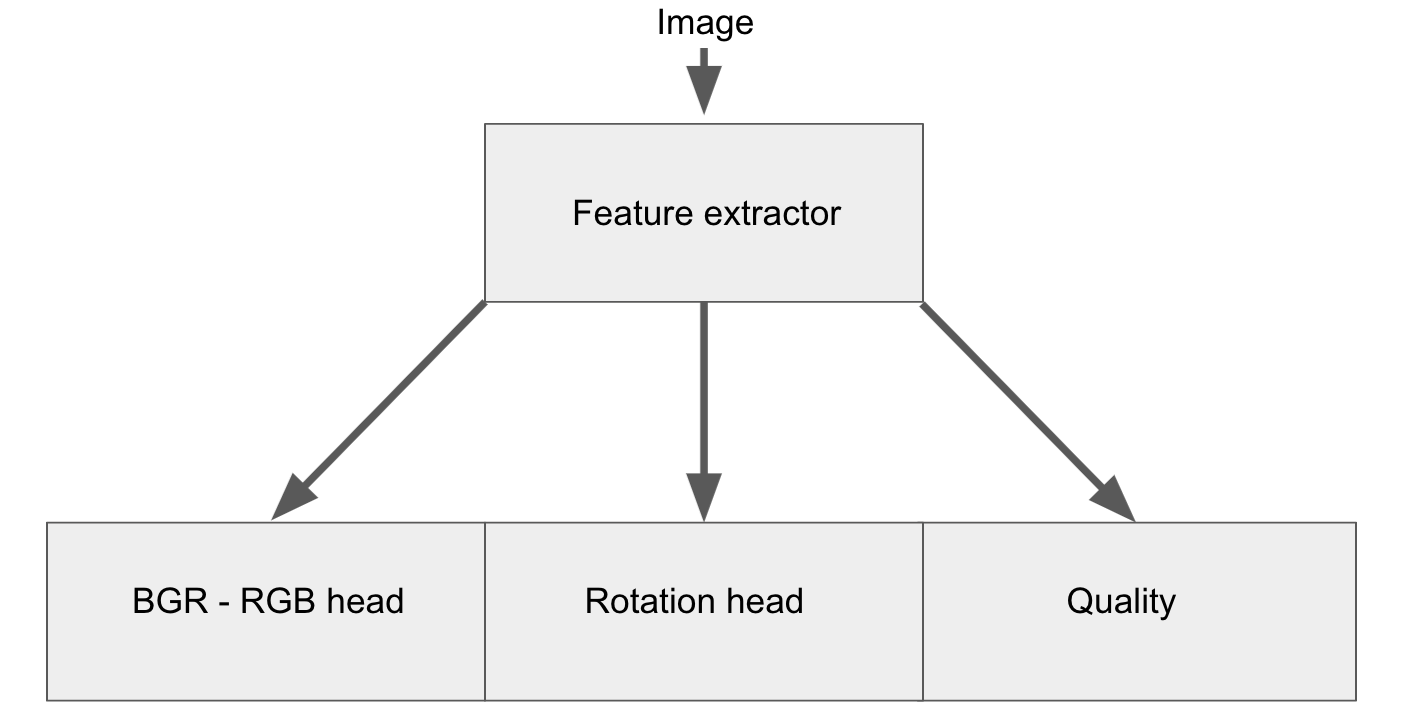

# На вход в классификатор подается изображение, на выходе должны быть вероятности для следующих классов:
### Выход качество: 

классы: 

1. Blur - фото смазано 

2. Torch -  фото засвечено

3. Sharp - фото хорошего качества, резкое

### Выход поворот:

классы: 

1. Поворот отсутствует 0 градусов

2. Поворот по часовой стрелке на 90 градусов

3. Поворот против часовой стрелке на 90 градусов

4. Перевернутое фото 180 градусов


### Выход  RGB-BGR:

классы:

1. RGB

2. BGR




 

## Особенности задания

1. Можно использовать любые открытые датасеты. Ниже найдете пример датасета.
2. Решение должно быть именно Вашим, уникальным и не повторяться с другими участниками.
4. Можно использовать любой удобный фреймворк (Pytorch, FastAI, Keras, Tensorflow)
5.Назовите папку для датасета DATASET_DIR в следующем формате : первая буква вашего имени,ваша фамилия, название датасета например : v_ivanov_images_dataset. Так мы сможем быстрее проверить решение


# Как начать
###Мы подготовили утилиты которые помогут в выполнении задания

#### Монтируем хранилище гугл в колаб (ваш датасет не пропадет если колаб отключится) 
перейдите по ссылке для авторизации для хранилища

скопируйте ключ в поле ввода

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgetk0qVG7e9bQsVL51XqYItqx0f5y07MQXB52kvLJscjHWoRlyuoo
Mounted at /content/gdrive


In [ ]:
if False:
  #создайте папку для датасета в хранилище
  #назовите папку в следующем формате : первая буква вашего имени,ваша фамилия, название датасета например : v_ivanov_images_dataset
  import os
  DATASET_DIR = "e_ugolnikova_images_dataset"
  FULL_PATH = os.path.join("/content/gdrive/MyDrive/",DATASET_DIR)
  os.makedirs(FULL_PATH,exist_ok=True)
  print(FULL_PATH)

# Загрузка датасета с kaggle

In [ ]:
if False:
  # set up kaggle json in colab and download the dataset
  # make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/YOURDISPLAYNAME/account

  ! pip install -q kaggle

  import os
  from google.colab import files

  if not os.path.exists("/root/.kaggle/kaggle.json"):
    files.upload()
    ! mkdir -p ~/.kaggle
    ! mv kaggle.json ~/.kaggle/ 
    ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
if False:
  # example downloading dataset
  !kaggle datasets download -d kwentar/blur-dataset
  !unzip -qq blur-dataset.zip -d ./

# Модель
Напишите здесь свою модель и визуализацию данных. 
Архитектура любая на ваше усмотрение (CNN, Transformers, SE blocks)
Используйте необходимые метрики, матрицу ошибок для анализа модели

Проверьте модель на тестовых данных 

# Folder with data, scripts, model
https://drive.google.com/drive/folders/18NlH4hf9yJ4lDMTn8f-Fivk81W1Hsi6i?usp=sharing

# Note about data
Выходы в таблицах train.csv и test.csv:


*   Качество (quality)
    *   0 - Sharp (Фото четкое)
    *   1 - Blur (Фото смазано)
    *   2 - Torch (Фото засвечено)
*   Поворот (rotation)
    *   0 - Поворот отсутсвует (Rotated by 0°)
    *   1 - Поворот против часовой стрелки на 90°(Rotated by 90°)
    *   2 - Поворот на 180° (Rotated by 180°)
    *   3 - Поворот по часовой стрелке на 90° (Rotated by 270°)
*   RGB-BGR (color_mode)
    *   0 - RGB
    *   1 - BGR



Import the necessary packages 

In [2]:
import os, csv, cv2
import random, numpy, imutils
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

Upload train dataset 

In [3]:
path_to_dataset = '/content/gdrive/MyDrive/e_ugolnikova_images_dataset/'

In [4]:
filenames = os.listdir(path_to_dataset)

with open(path_to_dataset + 'train.csv', 'r') as f:
  reader = csv.DictReader(f, delimiter=',')
  td = [{k: str(v) for k, v in row.items()} for row in reader]

train_data = pd.DataFrame(td)
# print(train_data)

In [5]:
long_train_df, short_df = train_test_split(train_data, test_size=0.15, random_state=1)
train_df, val_df = train_test_split(short_df, test_size=0.4, random_state=1)
del long_train_df
del short_df
# print(train_df)
# print(val_df)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
callbacks = [earlystop, learning_rate_reduction]  

# CNN Architecture Model
Model will contain three branches, one for each output class

Мне не совсем хватило времени доработать модель, но я представляю как ее можно доработать и что делать дальше.

> Для предсказания смазанного изображения мне понравился метод, использованный многими людьми при обработке датасета blur на платформе kaggle. Путем наложения фильтра skimage.filters.roberts выявляются хорошо различимые отличия в четких и смазанных изображениях, но отличий между четкими и засвеченными изображениями, увы, в таком случае нет. Чтобы отличить засвеченные изображения от четких и смазанных уместно выявить особенности контраста изображений/рассматривать гистограммы изображений. Вопрос в том, как объединить эти модицикафии изображения.

> Насчет различия RGB/BGR цветовых моделей. Я думала о том, что если мы берем в расчет реальные фотографии, то большое количество из них сделаны при каком-либо освещении, это фотографии людей или животных. В таком случае, подобные изображения можно выделить тем, что в них большая составляющая красных/желтых оттенков. А что касается BGR изображений, при их генерации я заметила, что в них, наоборот, преобладает синий цвет.



In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

In [8]:
class Network:
  @staticmethod
  def build_quality_branch(inputs, numQualities,
    finalAct="softmax", chanDim=-1):
    
    # x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
  
    # define a branch of output layers for the number of different
    # qualities: sharp, blurred, torch
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    print(x)
    x = Dense(numQualities)(x)
    x = Activation(finalAct, name="quality_output")(x)
    
    return x

  @staticmethod
  def build_color_mode_branch(inputs, numColorMods, finalAct="softmax",
    chanDim=-1):
    
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
  
    # define a branch of output layers for the number of different
    # color mods: RGB, BGR
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(numColorMods)(x)
    x = Activation(finalAct, name="color_mode_output")(x)
    
    return x

  @staticmethod
  def build_rotation_branch(inputs, numRotations, finalAct="softmax",
    chanDim=-1):
    
    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
  
    # define a branch of output layers for the number of different
    # rotations: 0, 90, 180, 270
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(numRotations)(x)
    x = Activation(finalAct, name="rotation_output")(x)

    return x


  @staticmethod
  def build(width, height, numQualities, numRotations, numColorMods,
    finalAct="softmax"):
    
    inputShape = (height, width, 3)
    chanDim = -1
    # construct sub-networks
    inputs = Input(shape=inputShape)
    qualityBranch = Network.build_quality_branch(inputs, numQualities, finalAct=finalAct, chanDim=chanDim)
    color_modeBranch = Network.build_color_mode_branch(inputs, numColorMods, finalAct=finalAct, chanDim=chanDim)
    rotationBranch = Network.build_rotation_branch(inputs, numRotations, finalAct=finalAct, chanDim=chanDim)
    
    model = Model(
      inputs=inputs,
      outputs=[qualityBranch, rotationBranch, color_modeBranch],
      name="finalmodel")
    
    return model

In [16]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 25
INIT_LR = 1e-3
BS = 16
IMAGE_DIMS = (500, 500, 3)

In [17]:
model = Network.build(500, 500,
	numQualities=3,
	numRotations=4,
  numColorMods=2,
	finalAct="softmax")

losses = {
	"quality_output": "sparse_categorical_crossentropy",
	"rotation_output": "sparse_categorical_crossentropy",
	"color_mode_output": "sparse_categorical_crossentropy",
}
lossWeights = {"quality_output": 1.0, "rotation_output": 1.0, "color_mode_output": 1.0}

print("compiling..")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dropout_13/Identity:0', description="created by layer 'dropout_13'")
compiling..
Model: "finalmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 500, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 500, 500, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 500, 500, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
activation_18 (Acti

# Prepare train and validation data

Get the image paths:

In [11]:
image_paths = val_df['path'].to_list()
random.seed(42)
random.shuffle(image_paths)
data = []
list_qualityLabels = []
list_color_modeLabels = []
list_rotationLabels = []

Load the images, pre-process them and store in the data list:

In [12]:
for image_path in image_paths:
  image = cv2.imread(path_to_dataset + image_path.replace('\\','/'))
  image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = img_to_array(image)
  data.append(image)

  row = val_df.loc[val_df['path'] == image_path]
  row = row.to_string().split()
  list_qualityLabels.append(int(row[-3]))
  list_rotationLabels.append(int(row[-2]))
  list_color_modeLabels.append(int(row[-1]))

qualityLabels = numpy.array(list_qualityLabels)
rotationLabels = numpy.array(list_rotationLabels)
color_modeLabels = numpy.array(list_color_modeLabels)

In [13]:
data = numpy.array(data, dtype="float") / 255.0
print("data matrix: {} images ({:.2f}MB)".format(len(image_paths), data.nbytes / (1024 * 1000.0)))

split = train_test_split(data, qualityLabels, rotationLabels, color_modeLabels, test_size=0.2, random_state=42)
(trainX, testX, trainQualityY, testQualityY, trainRotationY, testRotationY, trainColormodeY, testColormodeY) = split

del data

data matrix: 454 images (2660.16MB)


Fit and save the model:

In [26]:
# Fit the model
H = model.fit(x=trainX, y={"quality_output": trainQualityY, "rotation_output": trainRotationY, "color_mode_output":trainColormodeY},
  validation_data=(testX, {"quality_output": testQualityY, "rotation_output": testRotationY, "color_mode_output":testColormodeY}),
  epochs=EPOCHS, verbose=1, callbacks = callbacks)

# save the model to google drive
print("[INFO] serializing network...")


Epoch 1/25
12/12 [==============================] - 231s 19s/step - loss: 4.4547 - quality_output_loss: 1.0401 - rotation_output_loss: 2.1450 - color_mode_output_loss: 1.2696 - quality_output_accuracy: 0.7052 - rotation_output_accuracy: 0.3085 - color_mode_output_accuracy: 0.6061 - val_loss: 5.5097 - val_quality_output_loss: 2.0741 - val_rotation_output_loss: 1.4226 - val_color_mode_output_loss: 2.0131 - val_quality_output_accuracy: 0.2857 - val_rotation_output_accuracy: 0.3187 - val_color_mode_output_accuracy: 0.4945
Epoch 2/25
12/12 [==============================] - 234s 20s/step - loss: 2.6283 - quality_output_loss: 0.5072 - rotation_output_loss: 1.4838 - color_mode_output_loss: 0.6373 - quality_output_accuracy: 0.8237 - rotation_output_accuracy: 0.4656 - color_mode_output_accuracy: 0.7548 - val_loss: 9.4065 - val_quality_output_loss: 2.2680 - val_rotation_output_loss: 1.5380 - val_color_mode_output_loss: 5.6005 - val_quality_output_accuracy: 0.3297 - val_rotation_output_accuracy: 

In [27]:
model.save(path_to_dataset)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/e_ugolnikova_images_dataset/assets


# Loss/Accuracy Visualisation

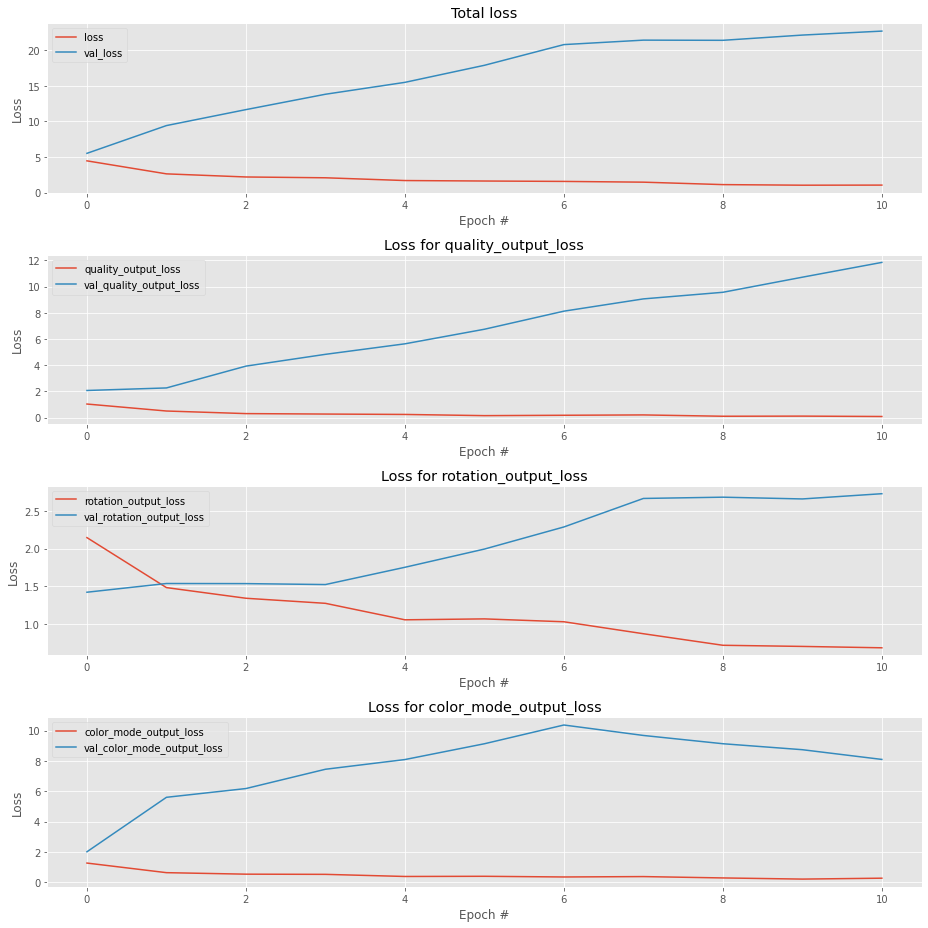

In [38]:
lossNames = ["loss", "quality_output_loss", "rotation_output_loss", "color_mode_output_loss"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(4, 1, figsize=(13, 13))
Epoch = 11
# Epoch = EPOCHS
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(numpy.arange(0, Epoch), H.history[l], label=l)
	ax[i].plot(numpy.arange(0, Epoch), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()
 
plt.tight_layout()
plt.savefig("{}_losses2.png".format(path_to_dataset))

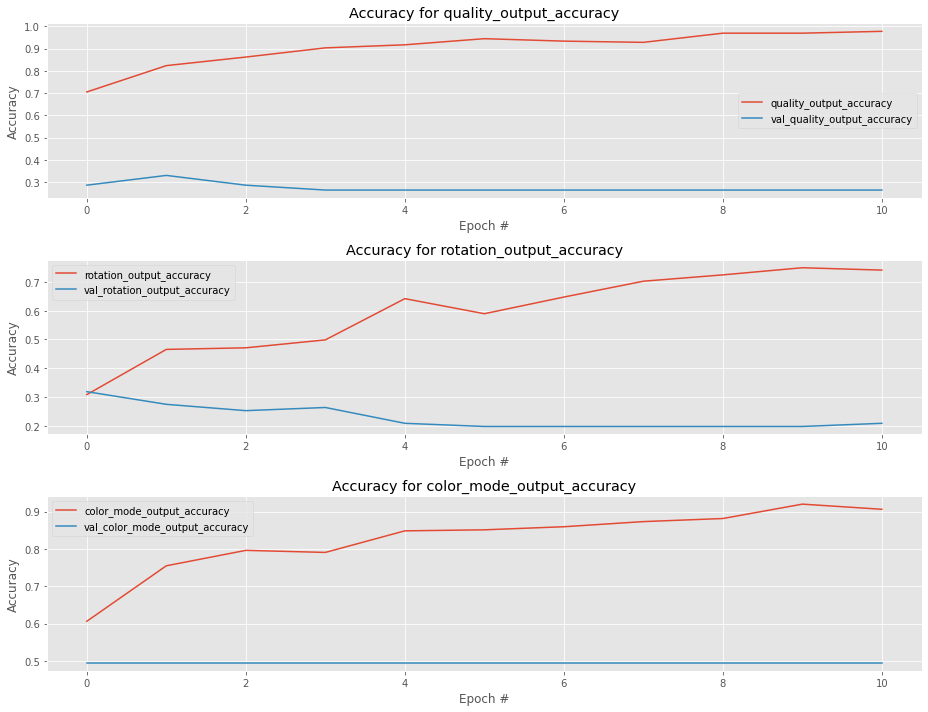

In [37]:
accuracyNames = ["quality_output_accuracy", "rotation_output_accuracy", "color_mode_output_accuracy"]
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 10))

for (i, l) in enumerate(accuracyNames):
	# plot the loss for both the training and validation data
	ax[i].set_title("Accuracy for {}".format(l))
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Accuracy")
	ax[i].plot(numpy.arange(0, Epoch), H.history[l], label=l)
	ax[i].plot(numpy.arange(0, Epoch), H.history["val_" + l],
		label="val_" + l)
	ax[i].legend()
 
plt.tight_layout()
plt.savefig("{}_accs2.png".format(path_to_dataset))


In [21]:
def check_image(model, path_to_test_image, size):
  image = cv2.imread(path_to_test_image)
  output = imutils.resize(image, width=size)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (size, size))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = numpy.expand_dims(image, axis=0)

  # print("[INFO] classifying image...")
  (quality_prob, rotation_prob, color_mode_prob) = model.predict(image)

  quality_idx = quality_prob[0].argmax()
  rotation_idx = rotation_prob[0].argmax()
  color_mode_idx = color_mode_prob[0].argmax()

  return [quality_idx, rotation_idx, color_mode_idx]


In [28]:
model = load_model(path_to_dataset)

In [29]:
qualities = {'0': 'sharp', '1': 'blurred', '2': 'torch'}
rotations ={'0': 'not_rotated', '1': 'rotated_left', '2': 'rotated_updown', '3': 'rotated_right'}
modes = {'0': 'RGB', '1': 'BRG'}

In [24]:
test_filenames = os.listdir(path_to_dataset + 'test/')

with open(path_to_dataset + 'test.csv', 'r') as f:
  reader = csv.DictReader(f, delimiter=',')
  test = [{k: str(v) for k, v in row.items()} for row in reader]

test_data = pd.DataFrame(test)

In [30]:
predicted_classes = []
true_classes = []

number_for_testing = 30
images_for_testing = random.sample(range(len(test_data.index)), number_for_testing)

for image in images_for_testing:
  temp = test_data.iloc[[image]]
  true_classes.append([int(temp.iloc[0, 1]), int(temp.iloc[0, 2]), int(temp.iloc[0, 3])])

  path_to_test_image = path_to_dataset + temp.iloc[0, 0].replace('\\', '/')
  predictions = check_image(model, path_to_test_image, 500)
  predicted_classes.append(predictions)

  img = cv2.imread(path_to_test_image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.xlabel("{}.jpg \npredicted: {}; {}; {} \nexpected: {}; {}; {} ".format(image, 
      qualities[str(predictions[0])], rotations[str(predictions[1])], modes[str(predictions[2])],
      qualities[str(true_classes[-1][0])], rotations[str(true_classes[-1][1])], modes[str(true_classes[-1][2])]))
  plt.tight_layout()
  plt.show() 



Output hidden; open in https://colab.research.google.com to view.

# Metrics of the model

In [31]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from  sklearn.metrics import classification_report

### Classification Report for Quality Class

In [32]:
qualities_targets = list(qualities.values())
q = [[row[0] for row in true_classes], [row[0] for row in predicted_classes]]
print(multilabel_confusion_matrix(q[0], q[1]))
print(classification_report(q[0], q[1], target_names=qualities_targets))

clf_report = classification_report(q[0], q[1], target_names=qualities_targets)

[[[17  0]
  [13  0]]

 [[ 0 22]
  [ 0  8]]

 [[21  0]
  [ 9  0]]]
              precision    recall  f1-score   support

       sharp       0.00      0.00      0.00        13
     blurred       0.27      1.00      0.42         8
       torch       0.00      0.00      0.00         9

    accuracy                           0.27        30
   macro avg       0.09      0.33      0.14        30
weighted avg       0.07      0.27      0.11        30



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification Report for Rotation Class

In [33]:
rotation_targets = list(rotations.values())
r = [[row[1] for row in true_classes], [row[1] for row in predicted_classes]]
print(multilabel_confusion_matrix(r[0], r[1]))
print(classification_report(r[0], r[1], target_names=rotation_targets))

[[[23  1]
  [ 6  0]]

 [[21  0]
  [ 9  0]]

 [[22  0]
  [ 8  0]]

 [[ 1 22]
  [ 0  7]]]
                precision    recall  f1-score   support

   not_rotated       0.00      0.00      0.00         6
  rotated_left       0.00      0.00      0.00         9
rotated_updown       0.00      0.00      0.00         8
 rotated_right       0.24      1.00      0.39         7

      accuracy                           0.23        30
     macro avg       0.06      0.25      0.10        30
  weighted avg       0.06      0.23      0.09        30



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification Report for Color Mode Class

In [34]:
modes_targets = list(modes.values())
c = [[row[2] for row in true_classes], [row[2] for row in predicted_classes]]
print(confusion_matrix(c[0], c[1]))
print(classification_report(c[0], c[1], target_names=modes_targets))

[[ 0 11]
 [ 0 19]]
              precision    recall  f1-score   support

         RGB       0.00      0.00      0.00        11
         BRG       0.63      1.00      0.78        19

    accuracy                           0.63        30
   macro avg       0.32      0.50      0.39        30
weighted avg       0.40      0.63      0.49        30



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Пример датасета 
https://www.kaggle.com/kwentar/blur-dataset









































































































# Контакты

Вопросы можно задать в 
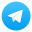


@ZackPashkin

@ASRomahin


Удачи в выполнении задания!